In [1]:
import numpy as np
import pandas as pd
import requests
import json 
import math
import time
import seaborn as sns
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from pandas import DataFrame
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso,LassoCV
from sklearn.preprocessing import scale 

# Reads in Necessary CSV files

In [2]:
citiesDf = pd.read_csv("bothCodesAndCities.csv")
citiesDf.columns = ['City','Codes','Label']
Distance = pd.read_csv('airports.csv')
labels = citiesDf['Label']
Distance.columns = ['City_Name','Distance']
cityList = Distance['City_Name'].tolist()
miles = Distance['Distance'].tolist()
cityList = Distance['City_Name'].tolist()
cityList[13] = 'Honolulu'
cityList[41] = "Hong Kong"
airportName = citiesDf['Codes'].tolist()
df1 = pd.read_csv('Begginning.csv')
df2 = pd.read_csv('last.csv')
df3 = pd.read_csv('midData.csv')

# Makes Data Frame

In [3]:
finalDf = pd.concat([df1,df2,df3], axis = 0)
finalDf = finalDf.reset_index()
finalDf = finalDf.drop('index', axis=1)
finalDf = finalDf.drop('Unnamed: 0', axis=1)

In [4]:
#Changes Date to number a number
def dateChanger(date):
    if date[5:7] == "01":
        day = int(date[8:10])
    elif date[5:7] == "02":
        day = int(date[8:10]) + 31
    elif date[5:7] == "03":
        day = int(date[8:10]) + 31 + 28
    elif date[5:7] == "04":
        day = int(date[8:10]) + 31 + 28 + 31
    elif date[5:7] == "05":
        day = int(date[8:10]) + 31 + 28 + 31 + 30
    elif date[5:7] == "06":
        day = int(date[8:10]) + 31 + 28 + 31 + 30 + 31
    elif date[5:7] == "07":
        day = int(date[8:10]) + 31 + 28 + 31 + 30 + 31 + 30
    elif date[5:7] == "08":
        day = int(date[8:10]) + 31 + 28 + 31 + 30 + 31 + 30 + 31
    elif date[5:7] == "09":
        day = int(date[8:10]) + 31 + 28 + 31 + 30 + 31 + 30 + 31 + 31
    elif date[5:7] == "10":
        day = int(date[8:10]) + 31 + 28 + 31 + 30 + 31 + 30 + 31 + 31 + 30
    elif date[5:7] == "11":
        day = int(date[8:10]) + 31 + 28 + 31 + 30 + 31 + 30 + 31 + 31 + 30 + 31
    elif date[5:7] == "12":
        day = int(date[8:10]) + 31 + 28 + 31 + 30 + 31 + 30 + 31 + 31 + 30 + 31 + 30
    else:
        day = -500
    return(day)

In [5]:
#Changes date to number of days
Date = finalDf['Flight Date'].tolist()
newDate = []
for i in range(len(Date)):
    newDate.append(dateChanger(Date[i]))
finalDf['Flight Date in days'] = pd.Series(newDate)

In [6]:
#Makes Dictionary
dicts = {}
dicts2 = {}
keys = cityList
values = miles
values2 = labels
for i in range(len(keys)):
    Key = keys[i]
    dicts[Key] = values[i]
    dicts2[Key] = values2[i]
Destination = finalDf['Destination'].tolist()
newDest = []
newLabel = []
for i in range(len(Destination)):
    newDest.append(dicts[Destination[i]])
    newLabel.append(dicts2[Destination[i]])
finalDf['Distance in miles'] = pd.Series(newDest)
finalDf['Label'] = pd.Series(newLabel)

In [7]:
#Finds Geodesic Distance
def geodesicDistance(coord1, coord2):
    R = 3958.8  # Earth radius in miles
    latitude1 = float(coord1[0])
    latitude2 = float(coord2[0])
    longitude1 = float(coord1[1])
    longitude2 = float(coord2[1])
    phi1 = math.radians(latitude1)
    phi2 = math.radians(latitude2)
    dphi = math.radians(latitude2 - latitude1)
    dlambda  = math.radians(longitude2 - longitude1)
    #Finds the distance between two points in a curve
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    distance = 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return(distance)

# Introduction

The main goals of this analysis is to predict airline tickets from LA and find the most important features in predicting airline ticket price. 

Our motivation for doing this analysis is because we have families abroad which we want to visit. Since we are college students
who need to save monety, it's in our best interest to plan in advance and know when to purchase our ticket when it's at its lowest prices.

# How Data was collected

We used the SkyScanner Api in order to get quotes on flights from one airport to another. In this case, we chose the Los Angeles International Airport (LAX) airport as a fixed "home" airport and obtained quotes from this airport to various destination around the globe using the API.

To keep our data manageable, we chose 33 domestics locations and 33 international locations as our destinations. We then attempted to pull airline price quotes for all 66 locations for 1 year starting December December 17th 2019 to December 21st 2020.

# EDA

We first plotted the price (our target), to see what the distribution looked liked. We noticed that it was skewed to the right. Because of this we log-transformed our target to normalize the distribution. Note that the log-transformed price variable has two peaks due to the two distinct price means in the data set, one for international flights and another for domestic flights.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


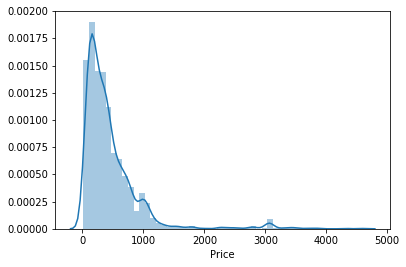

In [8]:
#Plot is right skewed
fig, ax = plt.subplots()
ax= sns.distplot(finalDf['Price'])
#fig.savefig("Figs/skewedPrice.png")

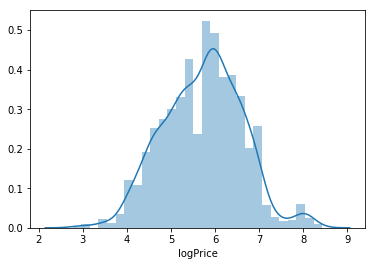

In [9]:
#Transformed plot looks better in terms of normality
price = [math.log(i) for i in finalDf['Price']]
finalDf['logPrice'] = pd.Series(price)
fig, ax = plt.subplots()
ax = sns.distplot(finalDf['logPrice'])
#fig.savefig("Figs/NormalPrice.png")

**Correlation Coefficients between Target and Features**

Note that both correlation values are low but it seems that the date a plane leaves has more impact than the distance a plane flies

In [10]:
corrDistance  = pearsonr(finalDf['Distance in miles'], finalDf['Price'])
corrDays = pearsonr(finalDf['Flight Date in days'], finalDf['Price'])
print(corrDays[0])
print(corrDistance[0])

0.19990533606595265
0.37634487277117823


**Interesting Data Summaries**

**Mean prices of Domestic Flights for each carrier**

**Note that Southwest is an outlier, API only gave qoutes for an expensive route that Southwest uses. (LAX to Rockford)**

In [11]:
domestic = finalDf[finalDf['Label'] == "D"]
domesticsPrice = domestic.groupby(['Carrier'])['Price'].mean()
domesticsPrice  = domesticsPrice.reset_index()
pd.DataFrame(domesticsPrice)

,Carrier,Price
0,Alaska Airlines,175.687023
1,Allegiant Air,87.500000
2,Frontier Airlines,92.882353
3,Hawaiian Airlines,207.312500
4,Linear Air,3662.000000
5,Southwest Airlines,1408.923077
6,Spirit Airlines,111.657895
7,Sun Country Airlines,183.333333
8,United,176.635036
9,jetBlue,158.315789


**Mean Prices of International Flights for each Carrier**

In [12]:
international = finalDf[finalDf['Label'] == "I"]
internationalPrice = international.groupby(['Carrier'])['Price','Distance in miles'].mean()
internationalPrice  = internationalPrice.reset_index()
international = pd.DataFrame(internationalPrice)
#5 most expensive airlines 
international.sort_values(by='Price', ascending=False).iloc[0:5,0:3]


,Carrier,Price,Distance in miles
31,Iberia,2258.000000,5832.913562
7,Air India,2013.000000,5981.869437
13,Avianca (Scheduled),1484.166667,5349.143207
38,Lufthansa,1296.842105,5812.138949
37,LOT,1096.000000,5978.377501


**Most expensive days to fly**

Note that its expensive to fly from any day past 307. This translates to any date past November 2nd. 

In [13]:
A = finalDf.groupby(['Flight Date in days'])['Price'].mean()
A  = A.reset_index()
#5 most Expensive day to Fly
A.sort_values(by='Price', ascending=False).iloc[0:5,0:3]

,Flight Date in days,Price
44,314,1235.785714
47,335,982.500000
46,328,966.555556
43,307,778.700000
48,351,755.708333


**Cheapest Day to fly**

Note that it's cheapest to fly for any day within day 35. This translated to any day within February 4th 

In [14]:
A = finalDf.groupby(['Flight Date in days'])['Price'].mean()
A  = A.reset_index()
#5 Cheapest Day to Fly
A.sort_values(by='Price', ascending=False).iloc[0:5,0:3]
A.head()

,Flight Date in days,Price
0,7,470.371429
1,14,387.188406
2,21,431.074627
3,28,369.352941
4,35,403.409091


In [15]:
#5 Cheapest airlines
international.sort_values(by='Price', ascending=True).iloc[0:5,0:3]

,Carrier,Price,Distance in miles
54,Volaris,123.450000,1553.451168
44,Royal Jordanian,134.333333,2171.411975
9,Air Tahiti Nui,139.000000,2171.411975
53,Viva Aerobus,142.611111,1553.451168
55,WestJet,182.594595,2171.411975


In [16]:
domesticDf = finalDf[finalDf['Label'] == "D"]
days = domesticDf['Flight Date in days']
subsetDf = domesticDf[['Carrier','Price','Flight Date in days']]
subsetDf = subsetDf.reset_index() 
pivotDf = subsetDf.pivot(index = 'index',columns ='Carrier', values = ['Price'])


In [17]:
def plotDf(countryDf,columnName):
    destinationPrice = countryDf
    destinationIndex = destinationPrice.index
    destinationDates = days[destinationIndex]
    destination = [columnName]*(len(destinationIndex))
    Price = pd.Series(destinationPrice.tolist())
    dates = pd.Series(destinationDates.tolist())
    destination = pd.Series(destination)
    newDf = pd.concat([Price,dates,destination], axis = 1)
    newDf.columns = ['Price','Days','Carriers']
    return(newDf)

In [18]:
names = pivotDf.columns
lineData = plotDf(pivotDf.iloc[:,0].dropna(),names[0][1])
for i in range(9):
    tempDf = plotDf(pivotDf.iloc[:,i].dropna(),names[i + 1][1])
    lineData = pd.concat([lineData,tempDf],axis = 0)

**Time series plot of prices with Domestic Carriers as hue**

**Takes out South West and Spirit Airlines since they contain many outlier points**

Note that in general, ticket prices tend to increase between the day 350 - 365 (December), days 80 - 100(March to April) and days 200 - 250(July - August).

<Figure size 720x720 with 0 Axes>

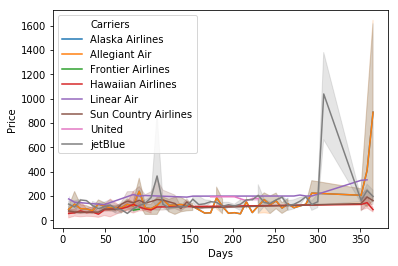

In [19]:
noOutliers = lineData[lineData['Carriers'] != "Spirit Airlines"]
noOutliers = noOutliers[(noOutliers['Carriers'] != "Southwest Airlines")]
plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
ax = sns.lineplot(x = 'Days',y = 'Price', hue = 'Carriers',data = noOutliers)
#fig.savefig("Figs/TSDomestic.png")

**Time series plot of prices with Foreign Carriers as hue**

In [20]:
internationalDf = finalDf[finalDf['Label'] == "I"]
days = internationalDf['Flight Date in days']
subsetDf = internationalDf[['Carrier','Price','Flight Date in days']]
subsetDf = subsetDf.reset_index() 
pivotDf = subsetDf.pivot(index = 'index',columns ='Carrier', values = ['Price'])

In [21]:
names = pivotDf.columns
lineData = plotDf(pivotDf.iloc[:,0].dropna(),names[0][1])
for i in range(7):
    tempDf = plotDf(pivotDf.iloc[:,i].dropna(),names[i + 1][1])
    lineData = pd.concat([lineData,tempDf],axis = 0)

In General, it's best to purchase plane tickets for international flights for the carriers mentioned below between the days 1 and 130 (January - May). Prices tend to increase drastically between days 300 - 365 which corresponds to October to December.

<Figure size 720x720 with 0 Axes>

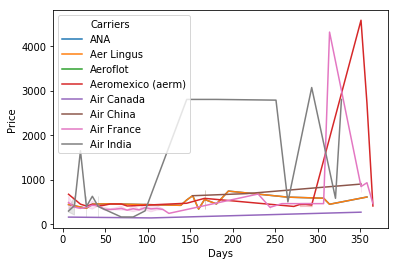

In [22]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
ax = sns.lineplot(x = 'Days',y = 'Price', hue = 'Carriers',data = lineData)
#fig.savefig("Figs/TSInternatinal.png")

In [23]:
names = pivotDf.columns
lineData = plotDf(pivotDf.iloc[:,8].dropna(),names[8][1])
for i in range(7):
    tempDf = plotDf(pivotDf.iloc[:,i + 7].dropna(),names[i + 8][1])
    lineData = pd.concat([lineData,tempDf],axis = 0)

Similar to the plot above, prices for these carriers tend to be low between days 1 - 130 (January to May). Note however that the prices for the carriers seems to increase at days 130 - 160 which corresponds to May 10th to June 9th.

<Figure size 720x720 with 0 Axes>

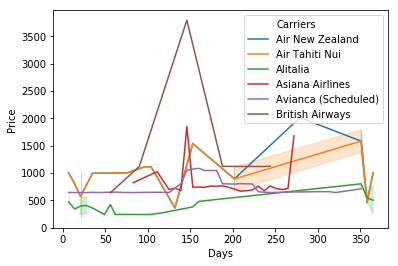

In [24]:
lineData = lineData[lineData['Carriers'] != 'Alaska Airlines']
plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
ax = sns.lineplot(x = 'Days',y = 'Price', hue = 'Carriers',data = lineData)
#fig.savefig("Figs/TSInternatinal.png")

**Scatter plot of Distance and price with Domestic and International as hue**

Note that there is Class skew in our data set since there is far more international flights than domestic flights.

<Figure size 720x720 with 0 Axes>

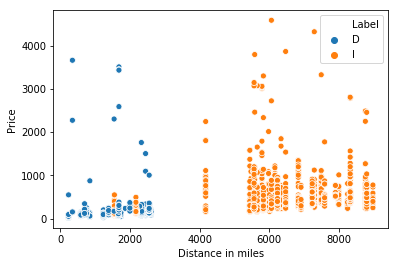

In [25]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
ax = sns.scatterplot(x = 'Distance in miles',y = 'Price', hue = 'Label',data = finalDf)
#fig.savefig("Figs/ScatterPlotDistance.png")

As expected, Domestic flights are much cheaper than international flights. Note the both boxplots have outliers.

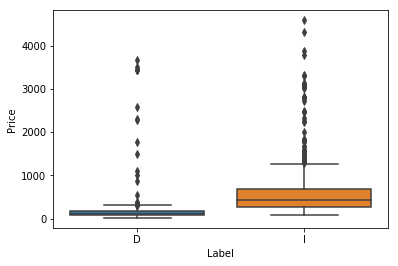

In [26]:
sns.boxplot(x="Label", y="Price", data=finalDf)

# Feature Engineering

**Creates Dummy variables for Destination and Carrier**

In [27]:
labelencoder=LabelEncoder()
labelC = labelencoder.fit_transform(finalDf['Carrier']).tolist()
labelD = labelencoder.fit_transform(finalDf['Destination']).tolist()
finalDf['Carrier'] = pd.Series(labelC)
finalDf['Destination'] = pd.Series(labelD)

**Subsets Data to the one needed for Machine learing**

In [28]:
Features = finalDf[['Carrier','Flight Date in days','Distance in miles','Direct','Destination']]
Target = finalDf['logPrice'].tolist()

# Test-Train Split

In [29]:
xTrainData,xTestData,yTrainData,yTestData = train_test_split(Features,Target, test_size = 0.30, 
  random_state = 801)

# Methods

**Selected models**

We chose **Lasso Regression** because it allows us to regularize ("shrink") coefficients. This means that the estimated coefficients for inconsequential features are pushed towards 0, which simplifies the model. This allows us to use a simpler models and avoid over-fitting at the same time. Since our goal is to find the feature which most effects the price of the flight ticket, lasso regression would be helpful in finding them.

We chose **Random Forest** and **Boosting** because they are both extension of ensembele methods. 

Ensemble methods, which combines several decision trees to produce better predictive performance than utilizing a single decision tree. The main principle behind the ensemble model is that a group of weak learners come together to form a strong learner. They have two types:

    1. Bagging 
    2. Boosting 
    
**Random Forest** is an extension over bagging. It takes one extra step where in addition to taking the random subset of data, it also takes the random selection of features rather than using all features to grow trees. This model would answer our big question of finding the most important features that affect our target(flight ticket price)

**Gradient Boosting** is an extension over boosting method.

    Gradient Boosting= Gradient Descent + Boosting.

It uses gradient descent algorithm which can optimize any differentiable loss function. An ensemble of trees are built one by one and individual trees are summed sequentially. This model would be a great fit for having low mean error value(our selected metric) since for every next tree, it will try to revocer the losss which is the difference between actual and predicted values.

**Strength and weaknesses of each model**

**Lasso Regression**

**<PROS**>
    
- Simplifies the model by making the coefficients of inconsequential features approach zero.
- Avoids over fitting

**<CONS**>
- Selected features will be highly biased.
- For n<<p (n-number of data points, p-number of features), LASSO selects at most n features.
- LASSO will select only one feature from a group of correlated features, the selection is arbitrary in nature.
- For different boot strapped data, the feature selected can be very different.
- Prediction performance is worse than Ridge regression.


**Random Forest**

**<PROS**>
    
- Handles higher dimensionality data very well.
- Handles missing values and maintains accuracy for missing data.

**<CONS**>

- Since final prediction is based on the mean predictions from subset trees, it won’t give precise values for the regression model.

**Gradient Boosting**

**<PROS**>
    
- Supports different loss function.
- Works well with interactions.

**<CONS**>

- Prone to over-fitting.
- Requires careful tuning of different hyper-parameters

# Methods

**Boosting**

In [30]:
boosting = GradientBoostingRegressor(loss = 'lad', n_estimators = 500,learning_rate = 0.5)
boosting.fit(xTrainData,yTrainData)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.5, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [31]:
yPredict = boosting.predict(xTestData)
meanError = mean_absolute_error(yTestData,yPredict)
print("Mean Error: ", meanError)

Mean Error:  0.20002070068647793


**Lasso Regression**

In [32]:
lasso = Lasso(max_iter = 10000, normalize = True)
crossVal = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
crossVal.fit(xTrainData,yTrainData)
lasso.set_params(alpha=crossVal.alpha_)
lasso.fit(xTrainData, yTrainData)
yPredict = lasso.predict(xTestData)

In [33]:
l_meanError = mean_absolute_error(yTestData,yPredict)
print("Mean Error: ", l_meanError)

Mean Error:  0.39364891802871205


**Random Forest**

In [34]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(xTrainData, yTrainData)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [35]:
rf_pred = rf.predict(xTestData)
rf_meanError = mean_absolute_error(yTestData,rf_pred)
print("Mean Error: ", rf_meanError)

Mean Error:  0.15839148911585113


# Summary and Findings

**Feature importance using a Lasso regression**

In [36]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
alphas = 10**np.linspace(10,-2,100)*0.5
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(xTrainData), yTrainData)
    coefs.append(lasso.coef_)
#Finds the most important feautures
names = []
for col in xTrainData.columns: 
    names.append(col) 
coefficients = lasso.coef_
importantFeatures = []
for i in range(len(coefficients)):
    if coefficients[i] != 0:
        importantFeatures.append(names[i])
importantFeatures

['Flight Date in days', 'Distance in miles']

**Feature importance using Random Forest**

In [37]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = xTrainData.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [38]:
feature_importances

,importance
Distance in miles,0.623762
Flight Date in days,0.151960
Destination,0.096859
Carrier,0.084329
Direct,0.043090


**Most important Features**

Both Lasso and the random forest model agree that the most important features are **'Flight Date in days'** and **'Distance in miles'.**

**Model Evaluation**

Our best model is **random forest** with a mean absolute error of 0.15839. **Gradient Boosting** was second place with a mean absolute error of 0.20258. The **Lasso** regression performed the worst with a mean abosolute error of 0.39364. This was due to the fact that the Lasso regression had higher variance; it only used two features in the model (Fligh Date in days and Distance in miles).

**What We learned**

Through our EDA, we learned that the most expensive domestic airline was **linear air**. This made sense since it was a private jet company.The cheapest domestic airiline was **Allegiant Air**. In terms of international airlines, the most expensive was **Iberia** while the cheapest was **Volaris**

Our EDA also revealed that the most expensive time to fly was between **November and December**, while the cheapest time to fly was between **February and March**. This made sense since November and December are the Holidays where a lot of people are travelling which increases demand for flight tickets while February and March are times when people are either at school or work which decreases the demand for flight tickets purchases.

Based on the random forest feature importance function, **Distance in miles** is the biggest predictor of the price of a plane ticket.

**Disadvantages of our Analysis**

The main disadvantage of our analysis was that we had very sparse data; each destination point only had about 30 price estimates for different Tuedays of the week. This was because gathering more data would take many hours that we do not have. The API also gave us bad data for some airline which made it seem that the airline charged its customers higher. Southwest is a prime example of this since the API only gave us qoutes for Southwest's more expensive route.

Based on the disadvantages of, we learned the importance of obtaining good data before starting any analysis and making machine learning model. In this case we could have obtained better data by randomizing the day in which the qoute is to be taken for a particular week. 

# Code that was used to gather Data

# SkyScanner API

**Before using API**

1) Make an account with https://rapidapi.com 
2) Go to this link: https://rapidapi.com/skyscanner/api/skyscanner-flight-search, click on the pricing tab and select basic( the free option). After this, click on the test endpoint. Make sure the status code is 200
3) Go to this link: https://rapidapi.com/dev132/api/city-geo-location-lookup, click on the test endpoint tab. Make sure the status code is 200.
4) If your status code 200 for both, copy your api key (Beside the X-RapidAPI-Key under the header parameters tab).
5) Store this as 'x-rapidapi-key':"Your api-key"
6) Before running the generateRequest function and the requestGenerator function, put your api key in the header bracket.

**Makes Data frame with price, carrier and Layover as features**

In [35]:
#Find the corresponding airport for each city
airportName = citiesDf['Codes'].tolist()
airportName = airportName[0:22]
cityList = cityList[0:22]
date = ['2019-12-17','2019-12-24','2019-12-31','2020-01-07','2020-01-14','2020-01-21','2020-01-28','2020-02-04',
       '2020-02-11','2020-02-18','2020-02-25','2020-03-03','2020-03-10','2020-03-17','2020-03-24','2020-03-31',
       '2020-04-07','2020-04-14','2020-04-21','2020-04-28','2020-05-05','2020-05-12','2020-05-19','2020-05-26',
       '2020-06-02','2020-06-09','2020-06-16','2020-06-23','2020-06-30','2020-07-07','2020-07-14','2020-07-21',
       '2020-07-28','2020-08-04','2020-08-11','2020-08-18','2020-08-25','2020-09-01','2020-09-08','2020-09-15',
       '2020-09-22','2020-09-22','2020-09-29','2020-10-06','2020-10-13','2020-10-20','2020-10-27','2020-11-03',
       '2020-11-10','2020-11-17','2020-11-24','2020-12-01','2020-12-08','2020-12-15','2020-12-22','2020-12-29']

In [42]:
def generateRequest(airport,date):
    url1 = "https://skyscanner-skyscanner-flight-search-v1.p.rapidapi.com/apiservices/browsequotes/v1.0/US/USD/en-US/LAX/"
    url2 = airport + "/"
    url3 = date
    url = url1 + url2 + url3
    headers = {'x-rapidapi-host': "skyscanner-skyscanner-flight-search-v1.p.rapidapi.com",
    'x-rapidapi-key': "84e4c6c1a0msh8c02297f59e03fdp170b8fjsn682e57da4f5d"}#Put yout api key here
    jsonFile = requests.request("GET", url, headers=headers)
    if jsonFile.status_code == 200:
        statusCode = 0
    else:
        statusCode = 1
    jsonFile = requests.request("GET", url, headers=headers).json()
    returnVal = [statusCode,jsonFile]
    return(returnVal)

In [41]:
def generateDataFrame(jsonFile,destination,date):
    data = [['Delete me', 'Delete me','Delete me','Delete me','Delete me']] 
    dataFrame = pd.DataFrame(data, columns = ['Price', 'Carrier','Direct','Destination','Flight Date']) 
    for i in range(len(jsonFile['Quotes'])):
        price = jsonFile['Quotes'][i]['MinPrice']
        direct = jsonFile['Quotes'][i]['Direct']
        carrier = jsonFile['Quotes'][i]['OutboundLeg']['CarrierIds'][0]
        #Get Carriers:
        carrierNum = []
        carrierName = []
        for i in range(len(jsonFile['Carriers'])):
            carrierNum.append(jsonFile['Carriers'][i]['CarrierId'])
            carrierName.append(jsonFile['Carriers'][i]['Name'])
        #Makes dictionaries with relevant info
        dicts = {'Price': price,'Carrier':carrierName[carrierNum.index(carrier)],'Direct': direct,'Destination': destination,'Flight Date': date}
        #Makes dataframe
        tempDf = pd.DataFrame(dicts, index=[0])
        dataFrame = pd.concat([dataFrame,tempDf],axis = 0)
    dataFrame = dataFrame.reset_index()
    dataFrame = dataFrame.drop(dataFrame.index[0])
    dataFrame = dataFrame.reset_index()
    dataFrame = dataFrame.drop('level_0', axis=1)
    dataFrame = dataFrame.drop('index', axis=1)
    return(dataFrame)

In [38]:
def finalDfGenerator(airport,iterator):
    data = [['Delete me', 'Delete me','Delete me','Delete me','Delete me']] 
    finalDf = pd.DataFrame(data, columns = ['Price', 'Carrier','Direct','Destination','Flight Date']) 
    toKeepCity = []
    destination = []
    flightDate = []
    qouteStatus = 0
    counter = 0
    for i in range(len(date)):
        counter = counter + 1
        returnVal = generateRequest(airport,date[i])
        statusCode = returnVal[0]
        json = returnVal[1]
        if statusCode == 0:
            print(counter)
            if 'message' in json:
                print("Exceeded API limit, resting for 1 minute")
                time.sleep(60)
            else:
                if (len(json['Quotes']) != 0 & counter <= 48):
                    tempDf = generateDataFrame(json,cityList[iterator],date[i])
                    finalDf = pd.concat([finalDf,tempDf],axis = 0)
        if counter == 48:
            counter = 0
            time.sleep(60)
        else:
            continue
    iterator = iterator + 1
    finalDf = finalDf.reset_index()
    finalDf = finalDf.drop(finalDf.index[0])
    finalDf = finalDf.reset_index()
    finalDf = finalDf.drop('level_0', axis=1)
    finalDf = finalDf.drop('index', axis=1)
    return(finalDf)

In [43]:
iterator = 0
dfFinal = finalDfGenerator(airportName[0],iterator)
for i in range(len(airportName) - 1):
    iterator = iterator + 1
    tempDf = finalDfGenerator(airportName[i + 1],iterator)
    dfFinal = pd.concat([dfFinal,tempDf])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
Exceeded API limit, resting for 1 minute
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
Exceeded API limit, resting for 1 minute
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
Exceeded API limit, resting for 1 minute
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Exceeded API limit, resting for 1 minute
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
1

In [45]:
len(dfFinal)

605